In [1]:
import autograd.numpy as np
from Functions import *

import matplotlib.pyplot as plt

In [2]:
from Functions import *
from Optimizations import *
from utils import *
from Saving import *

%load_ext autoreload

%autoreload 2

In [3]:
import time
import yaml

In [19]:
U, grad_U = get_potential(process)

In [21]:
X = np.linspace(-20, 20, 200)
Y = np.linspace(-20, 20, 200)
inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X) * len(Y))

out = U(inp).reshape(len(X), len(Y))
grad_out = grad_U(inp)

out = grad_out[0].reshape(len(X), len(Y))

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=out, x=X, y=Y, colorscale="Viridis")])

fig.update_layout(title='Function', autosize=False,
                  width=1000, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [64]:
a = np.array([10, -9.89])
b = np.array([-9.89, 10])

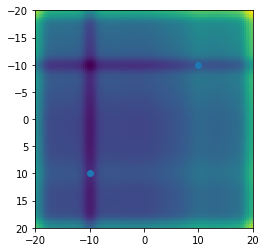

In [65]:
plt.imshow(out, extent=[X[0], X[-1], Y[-1], Y[0]])
plt.scatter(x=[a[0], b[0]], y=[a[1], b[1]])
plt.show()

In [36]:
g_params = [[-10, 1, -2], [0, 10, -1], [10, 3, 1], [-20, 1, 3], [20, 1, 3]]
attraction_params = {"alpha": 0.0025, "origin_point": [-9.89, 10]}
# g_params = [[-10, 0.7, -1], [0, 10, -1.5], [9, 3, 1], [17.5, 10, -0.5], [-20, 1, 3], [25, 1, 3]]
# g_params = [[-40, 0.7, -2],[-30, 0.7, -1.5],[-5, 0.7, -1], [35, 0.7, -1.5], 
#             [-17.5, 30, -3], [5, 10, -1.5], [14, 3, 1], [25, 10, -0.5], 
#             [-50, 1, 3], [50, 1, 3]]

process = {}

process["particle_init"] = {"name": "2d_position", 
                            "num_particles": 10,
                           "params": {"position": [10, -9.89]}}

process["potential_function"] = {"name": "2d_gaussian_symmetric_attraction", #} 
                                 "params": {"g_params": g_params, "attraction": attraction_params}}

process["total_iter"] = 1
process["tau"] = 100
process["x_range"] = [-25, 25]

process["gamma"] = 1
process["temperature"] = 0.75
process["epsilon"] = 0

process["weight_function"] = {"name": "norm"} 
# process["weight_function"] = {"name": "partial_norm", "params": {"partials": np.array([0])}} 

process["resample_function"] = {"name": "softmax", "params": {"beta": -0.5}} 

process["domain_enforcer"] = {"name": "hyper_cube_enforcer", "params": {"strength": 0.2}}

In [37]:
all_paths = diffusion_resampling(process, return_full_path=True)

In [38]:
# want to get order: big_timestep, tau_timestep, particle, point

f, grad_f = get_potential(process)

inp = all_paths.reshape([np.product(all_paths.shape[:3]), all_paths.shape[-1]]).T
out = f(inp)
all_paths_proc = np.concatenate([inp.T, out.reshape([len(out), 1])], axis=1).reshape(all_paths.shape[0], all_paths.shape[1], all_paths.shape[2], 3)

In [39]:
# get the function plot inputs
tmp_process = {}
tmp_process["potential_function"] = {"name": "2d_gaussian_symmetric", #} 
                                 "params": process["potential_function"]["params"]}

f, grad_f = get_potential(tmp_process)

X = np.linspace(process["x_range"][0], process["x_range"][1], 100)
Y = np.linspace(process["x_range"][0], process["x_range"][1], 100)
inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X)*len(Y))

Z = f(inp).reshape(len(X), len(Y))

In [40]:
# full process densities 
K = multi_gaussian(np.array([[0.6,  0], [0, 0.6]]))

folder_name = "full_{}_{}".format(process["potential_function"]["name"], process["tau"])
saved_path = create_animation_2d_pictures_particles(all_paths_proc, X, Y, Z, folder_name=folder_name, 
                                                    graph_details={"type": "contour", "p_size": 3, #"density_function": None})
                                                                    "density_function": None, #lambda inp, p: V(inp, K, p),
                                                                  "interpolation": "bilinear"})
create_animation(saved_path, "{}.mp4".format(folder_name), framerate=10)

time.sleep(3) # otherwise it deletes the images before getting the video
remove_png(saved_path)
save_config(saved_path, process)